In [2]:
import pandas as pd
import numpy as np
from __future__ import print_function, division

import os
import torch
from skimage import io, transform
import matplotlib.pyplot as plt 
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, utils

# Ignoring warnings
import warnings
warnings.filterwarnings("ignore")
plt.ion() # To initiate interactive mode

In [7]:
import random
labels_frame= pd.read_excel('/home/sps/Rajdeep_pytorch/BDRW_train_2/labels.xls')
print(len(labels_frame))
n=random.randint(0,200)
img_name_int= labels_frame.iloc[n,0]
img_name=img_name_int+'.jpg'
label= labels_frame.iloc[n,1]
print('Image Name : {}'.format(img_name))
print('Image Label :{}'.format(label))

1392
Image Name : digit_115.jpg
Image Label :4


The image shown below is: 4
The size of the image:(29, 15, 3) 


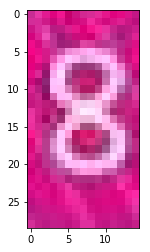

In [8]:
def show_imlab (image, label):
    sample={'image':image, 'label': label}
    plt.imshow(image)
    print('The image shown below is: {}'.format(label))
    print('The size of the image:{} '.format(image.shape))
plt.figure()
show_imlab(io.imread(os.path.join('BDRW_train_1/',img_name)),label)
plt.show()

In [45]:
height=32
width=32
import glob
from PIL import Image,ImageOps
for infile in glob.glob("/home/sps/Rajdeep_pytorch/BDRW_train_1/*.jpg"):
    file,ext= os.path.splitext(infile)
    im=Image.open(infile)
    im_new=ImageOps.fit(im,(width,height),Image.BICUBIC)
    im_new.save(file + ".jpg")
for infile in glob.glob("/home/sps/Rajdeep_pytorch/BDRW_train_2/*.jpg"):
    file,ext= os.path.splitext(infile)
    im=Image.open(infile)
    im_new=ImageOps.fit(im,(width,height),Image.BICUBIC)
    im_new.save(file + ".jpg")

(32, 32)
(32, 32)


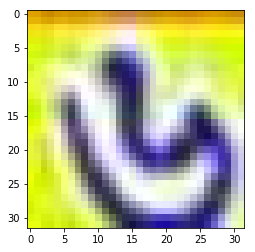

In [46]:
I=Image.open('/home/sps/Rajdeep_pytorch/BDRW_train_1/digit_1033.jpg')
print(I.size)
t=Image.open('/home/sps/Rajdeep_pytorch/BDRW_train_2/digit_1133.jpg')
print(t.size)
plt.imshow(t)

In [47]:
class TrainLoad(Dataset):
    def __init__(self,excel_file,root_dir,transform=None):
        self.df=pd.read_excel(excel_file)
        self.labels_frame=self.df.iloc[0:983,0:3]
        self.root_dir= root_dir
        self.transform=transform
    def __len__(self):
        return len(self.labels_frame)
    def __getitem__(self,idx):
        img_name_int=os.path.join(self.root_dir,self.labels_frame.iloc[idx,0])
        img_name=img_name_int+'.jpg'
        image=io.imread(img_name)
        label= self.labels_frame.iloc[idx,1]
        image = image.transpose((2, 0, 1))
        image = torch.from_numpy(image)
        image = image.new_tensor(image, dtype = torch.float)
        sample={'image':image, 'label': label}
        
        if self.transform:
            sample=self.transform(sample)
        return sample

In [48]:
class TestLoad(Dataset):
    def __init__(self,excel_file,root_dir,transform=None):
        self.df=pd.read_excel(excel_file)
        self.labels_frame=self.df.iloc[984:,0:3]
        self.root_dir= root_dir
        self.transform=transform
    def __len__(self):
        return len(self.labels_frame)
    def __getitem__(self,idx):
        img_name_int=os.path.join(self.root_dir,self.labels_frame.iloc[idx,0])
        img_name=img_name_int+'.jpg'
        image=io.imread(img_name)
        label= self.labels_frame.iloc[idx,1]
        image = image.transpose((2, 0, 1))
        image = torch.from_numpy(image)
        image = image.new_tensor(image, dtype = torch.float)
        sample={'image':image, 'label': label}
        
        if self.transform:
            sample=self.transform(sample)
        return sample

In [49]:
Test_Dataset= TestLoad(excel_file='BDRW_train_2/labels.xls',root_dir='/home/sps/Rajdeep_pytorch/BDRW_train_2/')
Train_Dataset=TrainLoad(excel_file='BDRW_train_2/labels.xls',root_dir='/home/sps/Rajdeep_pytorch/BDRW_train_1/')



In [50]:
trainloader=DataLoader(Train_Dataset,batch_size=4,shuffle=True,drop_last=True)
testloader=DataLoader(Test_Dataset,batch_size=4,shuffle=True,drop_last=True)
print(str(len(trainloader)))
print(len(testloader))

245
102


# Defining LeNet Architecture

In [51]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv1=nn.Conv2d(3,6,kernel_size = 5)           # 28*28*6
        self.pool=nn.MaxPool2d(kernel_size = 2,stride = 2)  # 14*14*6
        self.conv2=nn.Conv2d(6,16,kernel_size = 5)          # 10*10*16
        self.fc1=nn.Linear(16*5*5,120)                      # 5*5*16
        self.fc2=nn.Linear(120,84)
        self.fc3=nn.Linear(84,10)
        
    def forward(self,x):
        x=self.pool(F.relu(self.conv1(x)))
        x=self.pool(F.relu(self.conv2(x)))
        x=x.view(-1,16*5*5)
        x=F.relu(self.fc1(x))
        x=F.relu(self.fc2(x))
        x=self.fc3(x)
        return x
    
net=Net()
        
print(net)        

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


# Defining the Loss criterion

In [52]:
import torch.optim as optim

criterion=nn.CrossEntropyLoss()
optimiser=optim.Adam(net.parameters(), lr=1e-4)

# Training the Net

Iteration: 1 /30  ;  Training Loss: 0.576606 ; Testing Acc: 33.010 ; Time consumed: 0m 4s 
Iteration: 2 /30  ;  Training Loss: 0.365891 ; Testing Acc: 51.456 ; Time consumed: 0m 3s 
Iteration: 3 /30  ;  Training Loss: 0.248343 ; Testing Acc: 67.718 ; Time consumed: 0m 3s 
Iteration: 4 /30  ;  Training Loss: 0.189183 ; Testing Acc: 74.272 ; Time consumed: 0m 3s 
Iteration: 5 /30  ;  Training Loss: 0.148625 ; Testing Acc: 75.728 ; Time consumed: 0m 2s 
Iteration: 6 /30  ;  Training Loss: 0.112180 ; Testing Acc: 81.311 ; Time consumed: 0m 3s 
Iteration: 7 /30  ;  Training Loss: 0.089436 ; Testing Acc: 82.039 ; Time consumed: 0m 3s 
Iteration: 8 /30  ;  Training Loss: 0.069499 ; Testing Acc: 84.951 ; Time consumed: 0m 3s 
Iteration: 9 /30  ;  Training Loss: 0.059163 ; Testing Acc: 86.893 ; Time consumed: 0m 2s 
Iteration: 10 /30  ;  Training Loss: 0.043773 ; Testing Acc: 84.466 ; Time consumed: 0m 2s 
Iteration: 11 /30  ;  Training Loss: 0.038045 ; Testing Acc: 89.078 ; Time consumed: 0m 3

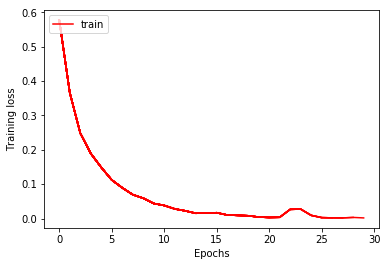

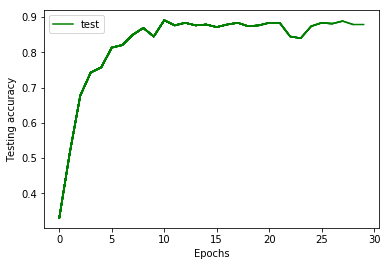

In [53]:
from torch.autograd import Variable
import time
iterations = 30
trainLoss = []
testAcc = []
start = time.time()
for epoch in range(iterations):
    epochStart = time.time()
    runningLoss = 0    
    net.train(True) # For training
    for data in trainloader:
        inputs,labels = data['image'], data['label']
        # Wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)  
       
        # Initialize gradients to zero
        optimiser.zero_grad()
        # Feed-forward input data through the network        
        outputs = net(inputs)        
        # Compute loss/error
        loss = criterion(outputs, labels)
        # Backpropagate loss and compute gradients
        loss.backward()
        # Update the network parameters
        optimiser.step()
        # Accumulate loss per batch
        runningLoss += loss.data[0]    
    avgTrainLoss = runningLoss/980.0
    trainLoss.append(avgTrainLoss)
    
    # Evaluating performance on test set for each epoch
    net.train(False) # For testing [Affects batch-norm and dropout layers (if any)]
    running_correct = 0
    for data in testloader:
        inputs,labels = data['image'], data['label']
        # Wrap them in Variable
        inputs = Variable(inputs)
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        #print('The predicted tensor: {}'.format(predicted))
        #print('The predicted label: {}'.format(labels))
        running_correct += (predicted == labels).sum()
        #print(running_correct)
        x=running_correct.data.numpy() 
    avgTestAcc = x/412.0
    #print(avgTestAcc)
    testAcc.append(avgTestAcc)
        
    # Plotting training loss vs Epochs
    fig1 = plt.figure(1)        
    plt.plot(range(epoch+1),trainLoss,'r-',label='train')        
    if epoch==0:
        plt.legend(loc='upper left')
        plt.xlabel('Epochs')
        plt.ylabel('Training loss')   
    # Plotting testing accuracy vs Epochs
    fig2 = plt.figure(2)        
    plt.plot(range(epoch+1),testAcc,'g-',label='test')        
    if epoch==0:
        plt.legend(loc='upper left')
        plt.xlabel('Epochs')
        plt.ylabel('Testing accuracy')    
    epochEnd = time.time()-epochStart
    print('Iteration: {:.0f} /{:.0f}  ;  Training Loss: {:.6f} ; Testing Acc: {:.3f} ; Time consumed: {:.0f}m {:.0f}s '\
          .format(epoch + 1,iterations,avgTrainLoss,avgTestAcc*100,epochEnd//60,epochEnd%60))
end = time.time()-start
print('Training completed in {:.0f}m {:.0f}s'.format(end//60,end%60))
